# Plan

Задача: Бинарная классификация срезов (есть опухоль/нет опухоли)

0. Load sample data
1. Setup VGG-like architecture
2. Simple DataLoader
3. Patch sampling & data augmentation
4. Batch training
5. Tensorboard

# 0. Resave data in different format

Folder structure:
 - subject_1
     - 1.npy
     - 1_mask.npy
     - 2.npy
     - 2_mask.npy
     - ...
     - [n_slices_subject1].npy
     - [n_slices_subject1]_mask.npy
 - subject_2
     - ...
 - ...
 - subject_n

In [1]:
from pathlib import Path

In [2]:
# import numpy as np
# from tqdm import tqdm

# data_folder = Path('/home/anvar/work/data/MICCAI_BraTS2020_TrainingData/')
# target_folder = Path('/home/anvar/work/data/brats_slices/')

# for subdir in tqdm(data_folder.glob('*')):
#     file = subdir.stem
#     img = nibabel.load(subdir / f'{file}_flair.nii.gz').get_fdata()
#     mask = nibabel.load(subdir / f'{file}_seg.nii.gz').get_fdata()
#     nonzero = np.nonzero(np.sum(img, (0, 1)))[0]
#     subfolder = target_folder / file
#     subfolder.mkdir()
    
#     for i in nonzero:        
#         np.save(subfolder / f'{i}.npy', img[..., i].astype(np.float32), )
#         np.save(subfolder / f'{i}_mask.npy', mask[..., i].astype(bool), )

# 1. Setup VGG-like architecture

More examples https://github.com/bentrevett/pytorch-image-classification/

![title](https://camo.githubusercontent.com/fed0475719a58ed51683e32c5fc4157051d1ba44/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f7667672e706e673f7261773d31)

In [3]:
import torch
import torch.nn as nn
from torch.nn import Sequential

`nn.Module` https://pytorch.org/docs/stable/generated/torch.nn.Module.html это базовый класс для определения архитектуры нейронной сети. От него следует наследовать любой класс определяющий нейронную сеть.

In [4]:
class VGGNet(nn.Module):
    def __init__(self):
        super().__init__() # super(VGGNet, self).__init__()
        pass
    
    def forward(self, x):
        return x

net = VGGNet()

`nn.Sequential` https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html это аналог `sklearn.pipeline.Pipeline` это функция, которая последовательно исполняет все функции переданные ей на вход:

```
g = Sequential(a, b, c)
g(x) эквивалентно c(b(a(x)))
```

In [5]:
def conv3x3(in_channels, out_channels, stride=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=(1, 1)),
        nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True)
    ]

class VGGNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = Sequential(
            *conv3x3(1, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            *conv3x3(32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            *conv3x3(32, 32),
            *conv3x3(32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            *conv3x3(32, 64),
            *conv3x3(64, 64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(5)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

net = VGGNet()

In [6]:
# Распаковка аргументов

a = [1, 2, 3]
b = [*a, 4, 5, 6]
c = [a, 4, 5, 6]

print(b)
print(c)

[1, 2, 3, 4, 5, 6]
[[1, 2, 3], 4, 5, 6]


In [7]:
rand_tensor = torch.rand((1, 1, 120, 120))

# Кол-во наблюдений x Кол-во каналов x Кол-во пикселей X x Кол-во пикселей Y

In [8]:
net.forward(rand_tensor)

tensor([[-0.4030]], grad_fn=<AddmmBackward>)

# 2. DataLoader

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

`torch.utils.data.Dataset` базовый класс описывающий набор данных. Для того чтобы написать собственный класс датасета, необходимо отнаследоваться от `torch.utils.data.Dataset` и перегрузить два метода:

- `__len__` возвращающий длину всего датасета, используя `len(dataset)`.
- `__getitem__` метод для поддержки индексации, т.е. для того чтобы можно было писать `dataset[i]` чтобы получить `i-ое` наблюдение.

In [9]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [10]:
class BraTSDataset(Dataset):
    def __init__(self, source_folder: [str, Path], transform=None):
        if isinstance(source_folder, str):
            source_folder = Path(source_folder)
            
        self.images = sorted(list(source_folder.glob('*')))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        
        file_name = self.images[i].stem.split('_')[-1]
        slices = list(self.images[i].glob('*'))
        slices = [s.stem for s in slices if 'mask' not in s.stem]
        np.random.shuffle(slices)
        j = slices[0]
        
        image = np.load(self.images[i] / f'{j}.npy', allow_pickle=True)
        mask = np.load(self.images[i] / f'{j}_mask.npy', allow_pickle=True)
        sample = image, mask
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [11]:
data_folder = Path('/home/anvar/work/data/brats_slices/')
dataset = BraTSDataset(data_folder)

In [12]:
img, mask = dataset.__getitem__(2)

In [13]:
img.shape, mask.shape

((240, 240), (240, 240))

# 3. Patch sampling & data augmentation

In [14]:
from torchvision import transforms
import numpy as np
from skimage.transform import rotate

In [15]:
def random_crop(sample):
    
    image, mask = sample
    delta_h, delta_w = 20, 20
    h, w = image.shape
    new_h, new_w = 120, 120
    top = np.random.randint(0, h - delta_h - new_h)
    left = np.random.randint(0, w - delta_w - new_w)

    image = image[top: top + new_h,
                  left: left + new_w]
    
    mask = mask[top: top + new_h,
                  left: left + new_w]
    
    return image, mask

def random_rotate(sample):
    
    image, mask = sample
    angles = [0, 90, 180, 270]
    np.random.shuffle(angles)
    angle = angles[0]    
    return rotate(image, angle), rotate(mask, angle)
    
def to_tensor(sample):
    image, mask = sample
    image = image.reshape(1, image.shape[0], image.shape[1])
    return torch.from_numpy(image), np.sum(mask, axis=(0,1)).astype(bool)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

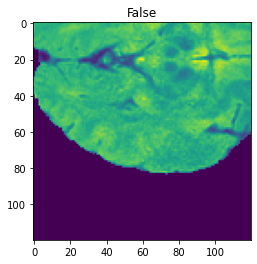

In [17]:
data_transform = transforms.Compose([
                    random_crop,
                    random_rotate,
                    to_tensor
            ])

_img, y = data_transform([img, mask])
plt.imshow(_img[0])
plt.title(y);

In [18]:
brats_dataset = BraTSDataset(data_folder, transform=data_transform)

In [19]:
dataset_loader = torch.utils.data.DataLoader(brats_dataset,
                                             batch_size=40, shuffle=True,
                                             num_workers=8)

In [20]:
for [imgs, ys] in dataset_loader:
    break

In [21]:
imgs.shape

torch.Size([40, 1, 120, 120])


# 4. Batch training (training loop)

In [22]:
import torch.optim as optim

In [23]:
device = ("cuda" if torch.cuda.is_available() else 'cpu')
model = VGGNet().float()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loader = dataset_loader

In [24]:
for epoch in range(5):
    epoch_loss = 0
    for X_batch, y_batch in dataset_loader:
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch.float())
        
        loss = criterion(y_pred, y_batch.float().unsqueeze(1))        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()        

    print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(dataset_loader):.5f}')

Epoch 000: | Loss: 1.27874
Epoch 001: | Loss: 0.68424
Epoch 002: | Loss: 0.71221
Epoch 003: | Loss: 0.57665
Epoch 004: | Loss: 0.57289


# 5. Tensorboard

In [25]:
from torch.utils.tensorboard import SummaryWriter

In [26]:
device = ("cuda" if torch.cuda.is_available() else 'cpu')
model = VGGNet().float()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loader = dataset_loader
tb = SummaryWriter()

Запусти `tensorboard --logdir runs` он запустится на `http://localhost:6006/` (порт может отличаться). После этого запускай обучение.

In [27]:
for epoch in range(5):
    epoch_loss = 0
    for X_batch, y_batch in dataset_loader:
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch.float())
        
        loss = criterion(y_pred, y_batch.float().unsqueeze(1))        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()        
    tb.add_scalar("Loss", epoch_loss/len(dataset_loader), epoch)
    
tb.close()

# TODO

1. Какое соотношение количества положительных и отрицательных примеров? Следует ли его изменить? Если да, то как?
2. Добавить подсчет точности на текущем батче. Добавить отображение в tensorboard.
3. Разделить выборку на тренировочную `train`, валидационную `validation` и тестовую `test` на основе subject_id. Например в отношении 80-10-10.
4. Добавить в `training loop` подсчет функции потерь на валидации `validation loss` каждые 5 эпох. Добавить отображение в tensorboard.
5. Добавить в `training loop` подсчет функции точности на валидации `validation accuracy` каждые 5 эпох. Добавить отображение в tensorboard.
6. Обучить нейросеть на тренировочной выборке, для определения момента остановки обучения ориентироваться на функцию потерь на валидационной выборке. Сравнить ошибку на валидации и на тесте.
7. Можно ли что-то сделать чтобы не мучиться в BraTSDataset с подгрузкой и расчетом путей к файлам?
8. Какие еще аугментации можно добавить кроме поворотов?
9. Нужен ли dropout в архитектуре на шаге предсказания?
